In [1]:
#%pip install torchmetrics
#%pip install lightning

In [2]:
import torch
import torch.nn.functional as F
import torchmetrics

import lightning as L

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from tests import test_category_embedder, test_house_price_regressor, print_dataset_info

B1. Data
---

a. Load the dataset using pandas

b. Create train, test and validation splits

c. Encode categorical features

d. Scale continuous features

e. Implement a PyTorch dataset

f. Create PyTorch dataloaders

### B1(a) Load the data using pandas

In [3]:
data = pd.read_csv("C:\\Users\\ZW\\Desktop\\NN&DL assignment\\files_PartB\\files_partB\\hdb_price_prediction.csv")

# define the continuous and categorical columns
continuous_cols = [
    "dist_to_nearest_stn",
    "dist_to_dhoby",
    "degree_centrality",
    "eigenvector_centrality",
    "remaining_lease_years",
    "floor_area_sqm",
]

categorical_cols = ["month", "town", "flat_model_type", "storey_range"]

# 4 categorical, 6 continuous, 1 target

### B1(b) Temporal split with validation

Create a temporal split:

1.	Train/Val pool: all rows with year <= 2020.

2.	From this pool, randomly sample 10% of the dataset to create a validation set.

3.	Test set: all rows with year == 2021.

4.	Print shapes (n_rows, n_cols) for train_data, val_data, test_data.

In [4]:
# Filter the rows where year <=2020
train_val_data = data[data['year'] <=2020]

columns_to_drop = ["year","full_address","nearest_stn"]

train_val_data = train_val_data.drop(columns=columns_to_drop)

train_data, val_data = train_test_split(
    train_val_data,
    test_size=0.1,
    random_state=42
)

test_data = data[data['year'] == 2021]

test_data = test_data.drop(columns=columns_to_drop)

In [5]:
# DO NOT MODIFY
train_data.shape, val_data.shape, test_data.shape

((78633, 11), (8737, 11), (29057, 11))

### B1(c) Encode categorical features w/o leakage

1.	Create an `sklearn.preprocessing.OrdinalEncoder` with handle_unknown="use_encoded_value", unknown_value=-1.

2.	Fit on train_data[categorical_cols] only.

3.	Transform val_data and test_data using the fitted encoder.

4. Compute and print the cardinality (number of distinct codes) for each categorical column on train_data after encoding. (These will be used to define embedding tables later.)

### B1(d) Scale continuous features w/o leakage

1.	Create a `StandardScaler`.

2.	Fit on train_data[continuous_cols] only.

3.	Transform val_data and test_data.

4.	Report the mean and std of each continuous feature on the transformed train split (they should be ~0 and ~1).

Do not scale resale_price.

In [6]:
from sklearn.preprocessing import OrdinalEncoder

# Initialise encoder
oe = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)

# Fit only on train_data
oe.fit(train_data[categorical_cols])

# Transform train, val and test
train_data[categorical_cols] = oe.transform(train_data[categorical_cols])
val_data[categorical_cols] = oe.transform(val_data[categorical_cols])
test_data[categorical_cols] = oe.transform(test_data[categorical_cols])

# Count distinct codes per categorical column
distinct_counts = train_data[categorical_cols].nunique()

# Put into DataFrame for readability
feature_stats = pd.DataFrame({
    "num_distinct_codes": distinct_counts
})

print(feature_stats)

                 num_distinct_codes
month                            12
town                             26
flat_model_type                  43
storey_range                     17


In [7]:
from sklearn.preprocessing import StandardScaler

# Fit scaler on train only
scaler = StandardScaler()
scaler.fit(train_data[continuous_cols])

# Transform train, val and test
train_data[continuous_cols] = scaler.transform(train_data[continuous_cols])
val_data[continuous_cols] = scaler.transform(val_data[continuous_cols])
test_data[continuous_cols] = scaler.transform(test_data[continuous_cols])

# Get mean and std from train_data
means = train_data[continuous_cols].mean()
stds = train_data[continuous_cols].std()

feature_stats = pd.DataFrame({
    "mean": means,
    "std": stds
})

print(feature_stats)

                                mean       std
dist_to_nearest_stn    -1.241573e-16  1.000006
dist_to_dhoby           9.216914e-17  1.000006
degree_centrality      -2.932244e-16  1.000006
eigenvector_centrality -1.265067e-17  1.000006
remaining_lease_years   3.099865e-16  1.000006
floor_area_sqm          3.377728e-16  1.000006


In [8]:
# DO NOT MODIFY
train_data.shape, val_data.shape, test_data.shape

((78633, 11), (8737, 11), (29057, 11))

### B1(e) Implement a PyTorch Dataset

Implement HDBPriceDataset(Dataset) with:
- `__init__(self, data, categorical_cols, continuous_cols, target_col="resale_price")`

- `__getitem__(idx)` returns a dict: {"x_cat": LongTensor, "x_cont": FloatTensor, "y": FloatTensor}

In [9]:
from torch.utils.data import DataLoader, Dataset

class HDBPriceDataset(Dataset):
    def __init__(self,data, categorical_cols, continuous_cols, target_cols="resale_price"):
        """
        Args:
            data (_type_): preprocessed dataframe
            categorical_cols (_type_): names of categorical columns
            continuous_cols (_type_): names of continuous columns
            target_cols (str): name of target column: "resale_price".
        """
        self.data = data.reset_index(drop=True)
        self.categorical_cols = categorical_cols
        self.continuous_cols = continuous_cols
        self.target_cols = target_cols
        
        # Extract values as numpy arrays for speed
        self.X_cat = self.data[categorical_cols].values.astype("int64")     # categorical
        self.X_cont = self.data[continuous_cols].values.astype("float32")   # continuous
        self.y = self.data[target_cols].values.astype("float32")            # target
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return{
            "x_cat": torch.tensor(self.X_cat[idx], dtype=torch.long),       # LongTensor for embeddings
            "x_cont": torch.tensor(self.X_cont[idx], dtype=torch.float32),  # FloatTensor
            "y": torch.tensor(self.y[idx], dtype=torch.float32)             # FloatTensor
        }

### B1(f) Create train, validation and test data loaders

Create train, validation and test datasets and data loaders. Use a batch size of 1024

In [10]:
batch_size = 1024

# Datasets
train_dataset = HDBPriceDataset(train_data, categorical_cols, continuous_cols, target_cols="resale_price")
val_dataset = HDBPriceDataset(val_data, categorical_cols, continuous_cols, target_cols="resale_price")
test_dataset = HDBPriceDataset(test_data, categorical_cols, continuous_cols, target_cols="resale_price")

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [11]:
# DO NOT MODIFY
print_dataset_info(train_dataset, test_dataset, train_loader, test_loader)

Dataset info:
Train samples: 78,633
Test samples: 29,057
Total batches (train): 77
Total batches (test): 29

Sample batch shapes:
Categorical: torch.Size([1024, 4])
Continuous: torch.Size([1024, 6])
Target: torch.Size([1024])


In [12]:
for i, batch in enumerate(train_loader):
    if i>=5:
        break
    print(f"Batch {i+1}:")
    print(batch)

Batch 1:
{'x_cat': tensor([[10, 22, 31,  2],
        [ 9, 17, 21,  0],
        [ 1, 17, 21,  1],
        ...,
        [ 4, 13,  9,  4],
        [ 6, 21, 10,  1],
        [ 8, 10, 23,  1]]), 'x_cont': tensor([[ 0.0804,  0.6693, -0.1368, -0.3089, -0.0072,  1.4503],
        [-1.0727,  0.5109, -0.1368, -0.3107,  1.1389, -0.1962],
        [-0.6698,  0.4267, -0.1368, -0.3107,  1.4801, -0.1962],
        ...,
        [-0.2663,  0.7713, -0.1368, -0.3109,  1.3964, -1.1841],
        [ 0.5020, -0.9545,  3.3430,  0.1526, -0.6446, -1.2664],
        [-1.2466, -1.0047, -0.1368, -0.1027,  0.4564, -0.6078]]), 'y': tensor([515000., 428000., 420000.,  ..., 350000., 308000., 391000.])}
Batch 2:
{'x_cat': tensor([[ 9, 20, 18,  2],
        [ 2, 17, 18,  4],
        [ 2, 18,  8,  2],
        ...,
        [ 9,  1, 10,  1],
        [ 9, 20, 18,  4],
        [ 9, 16, 18,  3]]), 'x_cont': tensor([[ 3.6337, -0.1010, -0.1368, -0.3038,  1.5445, -0.2373],
        [ 0.9079,  0.4959, -0.1368, -0.3107,  1.4157, -0.1550]

In [13]:
for i, batch in enumerate(test_loader):
    if i>=5:
        break
    print(f"Batch {i+1}:")
    print(batch)

Batch 1:
{'x_cat': tensor([[ 0,  0,  3,  0],
        [ 0,  0,  3,  2],
        [ 0,  0, 10,  1],
        ...,
        [11,  0, 20,  3],
        [11,  0, 20,  1],
        [11,  0, 20,  0]]), 'x_cont': tensor([[ 0.9965, -0.6903, -0.1368, -0.1966, -0.8249, -2.1720],
        [ 0.9965, -0.6903, -0.1368, -0.1966, -0.8249, -2.1720],
        [ 0.1551, -1.0154, -0.1368, -0.0143, -1.2176, -1.2252],
        ...,
        [-1.0422, -0.5356, -0.1368, -0.1966, -1.3077, -0.2373],
        [ 0.1309, -0.7820, -0.1368, -0.0143, -1.4430,  0.0096],
        [-0.7506, -0.9116, -0.1368, -0.0143, -1.4945,  0.0096]]), 'y': tensor([211000., 225000., 260000.,  ..., 480000., 480000., 483000.])}
Batch 2:
{'x_cat': tensor([[11,  0, 20,  0],
        [11,  0, 20,  3],
        [11,  0,  9,  5],
        ...,
        [ 7,  1, 10,  3],
        [ 7,  1, 10,  1],
        [ 7,  1, 17,  2]]), 'x_cont': tensor([[-0.6690, -0.8801, -0.1368, -0.0143, -1.5009,  0.0096],
        [-0.1054, -0.9866, -0.1368, -0.0143, -1.2047, -0.2785]

B2. Model and training
---
a. Create a PyTorch Model

b. Write a LightningModule for fitting the model

c. Train the model

d. Predict using the trained model on the test set and calculate $R^2$

### B2(a) Create a PyTorch Model

In this part you will build a PyTorch model for tabular house-price regression that (i) embeds each categorical feature into a dense vector, (ii) concatenates all category embeddings with the standardized continuous features, and (iii) predicts resale_price via a small MLP.

You must implement two modules:
1.	CategoryEmbedder — one embedding table per categorical column plus optional dropout.

2.	HousePriceRegressor — uses CategoryEmbedder, concatenates with continuous features, then a 3-layer MLP.

You will then instantiate the model using provided cardinalities and embedding dimensions.

Use the same feature schema and encoded/scaled splits you produced in Part 1. Assume you already have train_loader, val_loader, test_loader, continuous_cols, oe (the fitted OrdinalEncoder), and batch_size.

A. Implement CategoryEmbedder (10 pts)

Create a module that receives:
- cardinalities: List[int] — number of distinct codes per categorical column (from oe.categories_).

- embed_dims: List[int] — embedding dimension for each categorical column (same length as cardinalities).

- emb_dropout: float — dropout applied after concatenation of all embeddings.

Requirements

1.	Construct a nn.ModuleList of nn.Embedding(num_embeddings=c, embedding_dim=d) for each (c, d) pair.

2.	In forward(x_cat), where x_cat has shape [B, C] (C = #categorical columns):

	- Look up each column i using its table: emb_i(x_cat[:, i]) → [B, d_i].

	- Concatenate along feature dimension → [B, sum(embed_dims)].

	- Apply Dropout(emb_dropout) and return.

In [14]:
import torch.nn as nn

class CategoryEmbedder(nn.Module):
    def __init__(self, cardinalities, embed_dims, emb_dropout=0.0):
        """Initialize the CategoryEmbedder.
        Args:
            cardinalities (list): List of integers representing the number of unique values for each categorical feature.
            embed_dims (list): List of integers representing the embedding dimensions for each categorical feature.
            embed_dropout (float): Dropout rate for the embeddings.
        """
        super().__init__()
        assert len(cardinalities) == len(embed_dims), "cardinalities and embed_dims are of same length"
        
        # One embedding table per categorical column
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=c, embedding_dim=d)
            for c, d in zip(cardinalities, embed_dims)
        ])
        
        self.dropout = nn.Dropout(emb_dropout)
        
    def forward(self, x_cat):
        """
        Args:
            x_cat: LongTensor of shape [B,C] where C = #categorical columns
        Returns:
            Tensor of shape [B, sum(embed_dims)] after dropout
        """
        embedded_cols = []
        for i, emb in enumerate(self.embeddings):
            embedded_col = emb(x_cat[:,i])  # [B, d_i]
            embedded_cols.append(embedded_col)
            
        # Concatenate all embeddings along feature dimension
        x = torch.cat(embedded_cols, dim=1) # [B, sum(embed_dims)]
        x = self.dropout(x)
        return x

In [15]:
test_category_embedder(CategoryEmbedder)

Test 1: Basic functionality
Input shape: torch.Size([32, 3])
Output shape: torch.Size([32, 14])
Expected output dim: 14
✓ Basic functionality test passed

Test 2: Single categorical feature
✓ Single feature test passed

Test 3: Edge case with minimum values
✓ Minimum values test passed

All tests passed! 🎉


In [16]:
class HousePriceRegressor(nn.Module):
    def __init__(self, cardinalities, embed_dims, n_continuous, emb_dropout=0.0):
        """Initialize the HousePriceRegressor.

        Args:
            cardinalities (list): List of integers representing the number of unique values for each categorical feature.
            embed_dims (list): List of integers representing the embedding dimensions for each categorical feature.
            n_continuous (int): Number of continuous features.
            emb_dropout (float, optional): Dropout rate for the embeddings. Defaults to 0.0.
        """
        super().__init__()
        
        # Category embedder
        self.cat_embedder = CategoryEmbedder(cardinalities, embed_dims, emb_dropout)
        
        # Input size for MLP = sum of embedding dims + number of continuous features
        input_size = sum(embed_dims) + n_continuous
        
        # Build a 3 layer MLP
        self.mlp = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(64,1)
        )
        
    def forward(self, x_cat, x_cont):
        """
        Args:
            x_cat: LongTensor [B,C] cateogrical features
            x_cont: FloatTensor [B,D] continuous features
        Returns:
            y_pred: FloatTensor [B,1] regression predictions
        """
        x_emb = self.cat_embedder(x_cat)            # [B. sum(embed_dims)]
        x = torch.cat([x_emb, x_cont], dim=1)       # [B, sum(embed_dims)+D]
        y_pred = self.mlp(x)                        # [B, 1]
        return y_pred.squeeze(1)

In [17]:
# DO NOT MODIFY
test_house_price_regressor(HousePriceRegressor)

Testing HousePriceRegressor...
Categorical input shape: torch.Size([32, 4])
Continuous input shape: torch.Size([32, 6])
Output shape: torch.Size([32])
Output type: torch.float32
Sample predictions: [0.04888150095939636, 0.0398675799369812, 0.07094309478998184, 0.06638914346694946, 0.10573919117450714]
✓ Basic functionality test passed
✓ Batch size 1 test passed
✓ Batch size 16 test passed
✓ Batch size 64 test passed
✓ Batch size 128 test passed

Model info:
Total parameters: 51,781
Trainable parameters: 51,781

All HousePriceRegressor tests passed! 🎉


In [18]:
# DO NOT MODIFY
cardinalities = [len(categories) for categories in oe.categories_]
embedding_dims = [min(50, (c + 1) // 2) for c in cardinalities]
n_continuous = len(continuous_cols)

# Create model with proper cardinalities
model = HousePriceRegressor(
    cardinalities=cardinalities,
    embed_dims=embedding_dims,
    n_continuous=n_continuous,
    emb_dropout=0.1,
)

In [19]:
print("Cardinalities: ", cardinalities)
print("Embedding dims: ", embedding_dims)
print("n_continuous: ", n_continuous)

Cardinalities:  [12, 26, 43, 17]
Embedding dims:  [6, 13, 22, 9]
n_continuous:  6


### B2(b) PyTorch LightningModule

Wrap your HousePriceRegressor into a PyTorch LightningModule so that training, validation, and testing are managed automatically.

What to do

1.	Initialize the module
    - Store hyperparameters (embedding sizes, number of continuous features, learning rate, etc.).

    - Create an instance of your HousePriceRegressor.

    - Choose a suitable regression loss function (e.g., MSE).

    - Set up at least one evaluation metric (e.g., MAE, RMSE).

2.	Forward method
    - Define a forward pass that takes categorical + continuous features and returns predictions.

3.	Training, Validation, and Test steps
    - In each step:
        - Extract features and target from the batch.

        - Run the model forward.

        - Compute the loss.

        - Log the loss and chosen metrics so they can be monitored.

4.	Prediction step
    - Implement a method to return predictions on new data without computing loss.

5.	Optimiser
    - Use a suitable optimiser (e.g., Adam) with a reasonable learning rate.

    - (Optional: add a scheduler if you wish to experiment.)

In [20]:
class HDBPriceLightningModule(L.LightningModule):
    def __init__(
        self,
        cardinalities,
        embedding_dims,
        n_continuous,
        emb_dropout):
        super().__init__()
        
        # Model
        self.model = HousePriceRegressor(cardinalities=cardinalities,
                                         embed_dims=embedding_dims,
                                         n_continuous=n_continuous,
                                         emb_dropout=emb_dropout)
        
        # Loss
        self.loss_fn = nn.MSELoss()
        
        # Metrics
        self.mae = torchmetrics.MeanAbsoluteError()
        self.rmse = torchmetrics.MeanSquaredError(squared=False)
        
    def forward(self, x_cat, x_cont):
        # Return 1D tensor predictions
        return self.model(x_cat, x_cont)
    
    def step(self,batch,stage=None):
        x_cat, x_cont, y = batch["x_cat"], batch["x_cont"], batch["y"]
        y_hat = self.forward(x_cat, x_cont)
        loss = self.loss_fn(y_hat, y)
        mae_val = self.mae(y_hat, y)
        rmse_val = self.rmse(y_hat, y)
        
        if stage:
            self.log(f"{stage}_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
            self.log(f"{stage}_MAE", mae_val, on_step=False, on_epoch=True, prog_bar=True)
            self.log(f"{stage}_RMSE", rmse_val, on_step=False, on_epoch=True, prog_bar=True)
            
        return loss
    
    def training_step(self, batch):
        return self.step(batch, stage="train")
    
    def validation_step(self, batch):
        return self.step(batch, stage="val")
    
    def test_step(self, batch):
        return self.step(batch, stage="test")
    
    def predict_step(self, batch):
        x_cat, x_cont = batch["x_cat"], batch["x_cont"]
        return self.forward(x_cat, x_cont)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [21]:
# DO NOT MODIFY
lightning_model = HDBPriceLightningModule(
    cardinalities=cardinalities,
    embedding_dims=embedding_dims,
    n_continuous=n_continuous,
    emb_dropout=0.1,
)

### B2(c) Train the model

What to do
1.	Checkpoints
    - Add a checkpoint callback that monitors validation loss and keeps the best models (e.g., top-k) plus the last checkpoint for resuming.

2.	Early stopping
    - Add early stopping on the same validation metric with a reasonable patience and a small min_delta (use a tiny positive value to require real improvement).

3.	Learning-rate tracking
    - Log the learning rate each epoch/step with a LR monitor so it’s visible in your logger.

4.	Experiment logging
    - Create a logger (e.g., TensorBoard) with a clear experiment name and save directory.

5.	Trainer configuration
    - Set a sensible number of epochs, devices/accelerator (CPU/GPU), and enable gradient clipping.

    - Turn on progress bar and model summary for visibility.

    - Choose an appropriate logging frequency for your dataset size.

6.	Fit & Test
- Call trainer.fit(model, train_loader, val_loader).

- Optionally run trainer.test(model, test_loader) after training and print metrics.

7. Download the plots for validation loss, your validation metric and display it.

In [22]:
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

In [23]:
# Checkpoint: save best model based on val_loss + last checkpoint
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    save_top_k=1,
    mode="min",
    save_last=True,
    filename="{epoch:02d}-{val_loss:.4f}"
)

# Early stopping: stop if val_loss does not improve
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=5,         # number of epochs to wait
    min_delta=1e-4,     # small imrpovement required
    mode="min",
    verbose=True
)   

# Learning rate monitor
lr_monitor = LearningRateMonitor(logging_interval="epoch")

In [24]:
logger = TensorBoardLogger(
    save_dir="lightning_logs",
    name="HDBPriceRegression"
)

In [25]:
trainer = L.Trainer(
    max_epochs = 50,
    accelerator="auto",             # GPU if available
    devices=1,                      # number of devices
    gradient_clip_val=1.0,          # gradient clipping
    callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
    logger=logger,
    log_every_n_steps=10,           # adjust logging frequency
    enable_progress_bar=True, 
    enable_model_summary=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [26]:
# Train 
trainer.fit(lightning_model, train_loader, val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | HousePriceRegressor | 57.3 K | train
1 | loss_fn | MSELoss             | 0      | train
2 | mae     | MeanAbsoluteError   | 0      | train
3 | rmse    | MeanSquaredError    | 0      | train
--------------------------------------------------------
57.3 K    Trainable params
0         Non-trainable params
57.3 K    Total params
0.229     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\ZW\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:484: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\ZW\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\ZW\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 215344201728.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 8002011136.000 >= min_delta = 0.0001. New best score: 207342190592.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 34233384960.000 >= min_delta = 0.0001. New best score: 173108805632.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 79309258752.000 >= min_delta = 0.0001. New best score: 93799546880.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 71203225600.000 >= min_delta = 0.0001. New best score: 22596325376.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 14319587328.000 >= min_delta = 0.0001. New best score: 8276738048.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 3931203072.000 >= min_delta = 0.0001. New best score: 4345534976.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 657573376.000 >= min_delta = 0.0001. New best score: 3687961600.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 365929728.000 >= min_delta = 0.0001. New best score: 3322031872.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 279016960.000 >= min_delta = 0.0001. New best score: 3043014912.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 139457792.000 >= min_delta = 0.0001. New best score: 2903557120.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 112225024.000 >= min_delta = 0.0001. New best score: 2791332096.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 53190912.000 >= min_delta = 0.0001. New best score: 2738141184.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 59240960.000 >= min_delta = 0.0001. New best score: 2678900224.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 97892608.000 >= min_delta = 0.0001. New best score: 2581007616.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 54209280.000 >= min_delta = 0.0001. New best score: 2526798336.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 69244416.000 >= min_delta = 0.0001. New best score: 2457553920.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 97913600.000 >= min_delta = 0.0001. New best score: 2359640320.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 116723968.000 >= min_delta = 0.0001. New best score: 2242916352.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 73449728.000 >= min_delta = 0.0001. New best score: 2169466624.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 41032576.000 >= min_delta = 0.0001. New best score: 2128434048.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 131621632.000 >= min_delta = 0.0001. New best score: 1996812416.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 62685184.000 >= min_delta = 0.0001. New best score: 1934127232.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 22811776.000 >= min_delta = 0.0001. New best score: 1911315456.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 77383168.000 >= min_delta = 0.0001. New best score: 1833932288.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 53439488.000 >= min_delta = 0.0001. New best score: 1780492800.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 16848256.000 >= min_delta = 0.0001. New best score: 1763644544.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 22443264.000 >= min_delta = 0.0001. New best score: 1741201280.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 25986944.000 >= min_delta = 0.0001. New best score: 1715214336.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 10579840.000 >= min_delta = 0.0001. New best score: 1704634496.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 11974016.000 >= min_delta = 0.0001. New best score: 1692660480.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 19270912.000 >= min_delta = 0.0001. New best score: 1673389568.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 12885120.000 >= min_delta = 0.0001. New best score: 1660504448.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 11445248.000 >= min_delta = 0.0001. New best score: 1649059200.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 22252928.000 >= min_delta = 0.0001. New best score: 1626806272.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 15929856.000 >= min_delta = 0.0001. New best score: 1610876416.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 3170176.000 >= min_delta = 0.0001. New best score: 1607706240.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 28840576.000 >= min_delta = 0.0001. New best score: 1578865664.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 8177536.000 >= min_delta = 0.0001. New best score: 1570688128.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 17867136.000 >= min_delta = 0.0001. New best score: 1552820992.000


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [27]:
# Test
test_results = trainer.test(lightning_model, test_loader)

print(test_results)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ZW\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_MAE          │       65298.9453125       │
│         test_RMSE         │       76320.171875        │
│         test_loss         │       5934746624.0        │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 5934746624.0, 'test_MAE': 65298.9453125, 'test_RMSE': 76320.171875}]


In [28]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

log_dir = "C:\\Users\\ZW\\Desktop\\NN&DL assignment\\files_PartB\\files_partB\\lightning_logs\\HDBPriceRegression\\version_0"
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

# List available tags
print(ea.Tags()["scalars"])

# Extract scalars
train_loss_events = ea.Scalars("train_loss")
val_loss_events = ea.Scalars("val_loss")
train_rmse_events = ea.Scalars("train_RMSE")
val_rmse_events = ea.Scalars("val_RMSE")

# Convert to lists
train_loss_vals = [e.value for e in train_loss_events]
val_loss_vals = [e.value for e in val_loss_events]
train_rmse_vals = [e.value for e in train_rmse_events]
val_rmse_vals = [e.value for e in val_rmse_events]

# Epoch numbers
epochs = range(1, len(train_loss_vals)+1)


['lr-Adam', 'val_loss', 'val_MAE', 'val_RMSE', 'epoch', 'train_loss', 'train_MAE', 'train_RMSE', 'test_loss', 'test_MAE', 'test_RMSE']


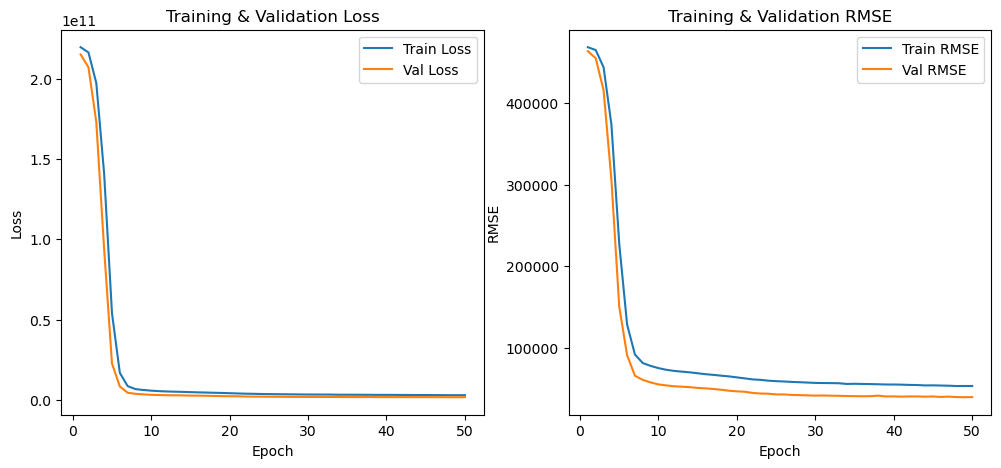

In [29]:
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(epochs, train_loss_vals, label="Train Loss")
plt.plot(epochs, val_loss_vals, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# RMSE curve
plt.subplot(1,2,2)
plt.plot(epochs, train_rmse_vals, label="Train RMSE")
plt.plot(epochs, val_rmse_vals, label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training & Validation RMSE")
plt.legend()

plt.show()

### B2(d) Model prediction and evaluation

1.	Run prediction
    - Use trainer.predict(model, test_loader) to generate predictions on the held-out test set.

    - Concatenate predictions into a single tensor/array.

2. Report results
    - Print R² (rounded to 4 decimal places).

    - Interpret the value of R² briefly

In [30]:
predictions = trainer.predict(lightning_model, dataloaders=test_loader)
preds = torch.cat([p.squeeze(-1) for p in predictions], dim=0)  # shape [num_test_samples]

# True labels
y_true_list = []
for batch in test_loader:
    y_true_list.append(batch["y"].squeeze(-1))  # shape [batch_size]
y_true = torch.cat(y_true_list, dim=0)


from sklearn.metrics import r2_score
r2 = r2_score(y_true.numpy(), preds.numpy())

print(f"R^2 on test set = {r2:.4f}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ZW\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

R^2 on test set = 0.7756


B3. Model Interpretability with Integrated Gradients
---

 What to do
1.	Choose an explainability method

    - Use Integrated Gradients (IG) from captum.attr.

    - Treat the continuous features (x_cont) as the primary inputs for attribution.

    - Pass categorical features (x_cat) as additional arguments to the forward function.

2.	Define a forward wrapper

    - Implement a wrapper function so IG knows how to call your model with both categorical and continuous features.

3.	Local explanation (per sample)

    - Run IG on a single batch from the training set.

    - Use a zero baseline for continuous features.

    - Plot the continuous features ranked by signed contribution for one example.

4.	Global explanation (across dataset)

    - Loop over the validation set to compute mean absolute attributions for each continuous feature.

    - Normalize by the number of samples.

    - Rank features by importance and plot a bar chart showing the most influential features globally.

5.	Interpret results

    - Report which features matter most for the model’s predictions.

    - Reflect briefly: Do these align with intuition (e.g., distance to station, floor area)?

In [31]:
#%pip install captum

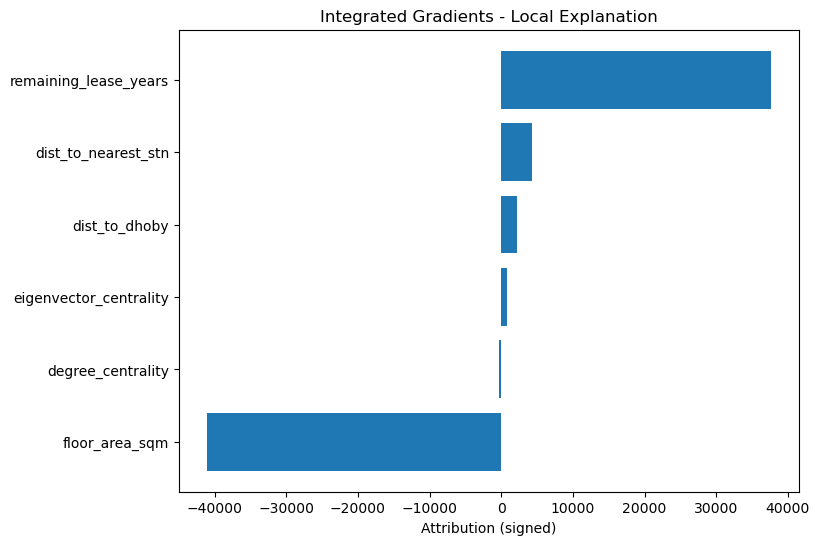

In [32]:
from captum.attr import IntegratedGradients

def forward_wrapper(x_cont, x_cat):
    return lightning_model(x_cat, x_cont)

# Initialise IG
ig = IntegratedGradients(forward_wrapper)

# Pick a batch from training set
batch = next(iter(train_loader))
x_cont_batch = batch["x_cont"] 
x_cat_batch = batch["x_cat"]
y_batch = batch["y"]

# Baseline = all zeros (same shape as x_cont_batch)
baseline = torch.zeros_like(x_cont_batch)

# Run IG for first sample
attributions, delta = ig.attribute(
    inputs=x_cont_batch[0].unsqueeze(0),
    baselines=baseline[0].unsqueeze(0),
    additional_forward_args=(x_cat_batch[0].unsqueeze(0).long(),),
    return_convergence_delta=True
)

# Convert to numpy
attr_np = attributions.squeeze().detach().numpy()

# Rank features by signed contribution
feature_names = continuous_cols
sorted_idx = np.argsort(attr_np)

plt.figure(figsize=(8,6))
plt.barh(np.array(feature_names)[sorted_idx], attr_np[sorted_idx])
plt.xlabel("Attribution (signed)")
plt.title("Integrated Gradients - Local Explanation")
plt.show()

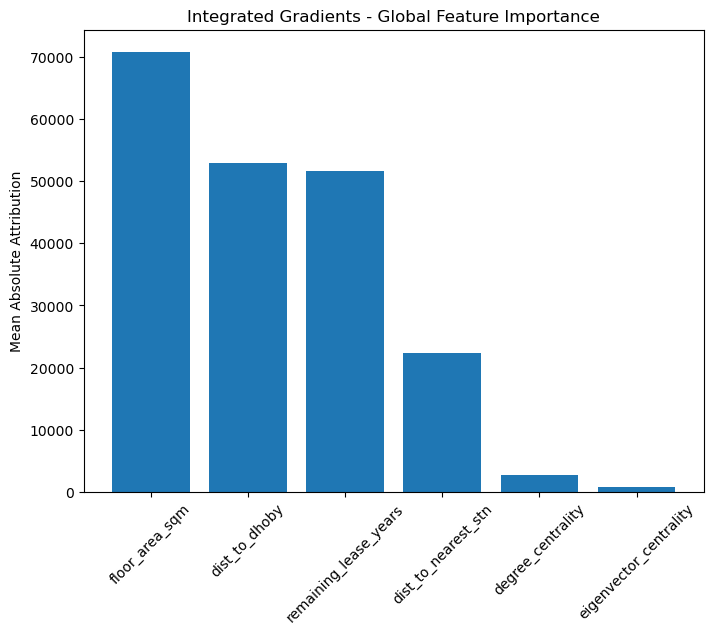

In [33]:
global_attr = torch.zeros(len(continuous_cols))

for batch in val_loader:
    x_cont = batch["x_cont"]
    x_cat = batch["x_cat"].long()
    
    baseline = torch.zeros_like(x_cont)
    attributions = ig.attribute(
        inputs=x_cont,
        baselines=baseline,
        additional_forward_args=(x_cat,),
        )
    
    global_attr += attributions.abs().sum(dim=0)
    
# Normalise by number of samples
global_attr /= len(val_loader.dataset)

# Convert to numpy for plotting
global_attr = global_attr.detach().numpy()
sorted_idx = np.argsort(global_attr)[::-1]

plt.figure(figsize=(8,6))
plt.bar(np.array(feature_names)[sorted_idx], global_attr[sorted_idx])
plt.ylabel("Mean Absolute Attribution")
plt.title("Integrated Gradients - Global Feature Importance")
plt.xticks(rotation=45)
plt.show()

#### The feature that mattered the most for model predictions is floor_area_sqm, followed by dist_to_dhoby, and then remaining_lease_years. This makes sense as the size of the HDB flat would affect the price and Dhoby Ghaut is a central area with an MRT station connected on multiple MRT lines. The remaining lease years also determines the price greatly as flats with less lease years then to be cheaper than those with more.